In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import keras
from keras.layers import Dense,SimpleRNN, GRU, LSTM, LeakyReLU, Dropout
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.utils import to_categorical
import numpy as np

input_path = './input.xlsx'

Using TensorFlow backend.


In [2]:
# read excel file
df = pd.read_excel(input_path)
# show top rows
df

,ID,Geology,Soil,Distance from rivers,Slope,Rainfall_2016,Rainfall_2017,Rainfall_2018,Rainfall_2019,Rainfall_2020,NDVI_2016,NDVI_2017,NDVI_2018,NDVI_2019,NDVI_2020,Distance from faults,Land use,Altitude,Aspect,Plan curvature,Profile curvature,SPI,STI,TWI,Distance from roads,X,Y,Label
0,1,0,0.666667,0.823491,0.017091,0.111545,0.037465,0.0,0.407423,0.032203,0.215265,0.300552,0.231388,0.455092,0.578278,0.917778,0.111111,0.078782,0.692665,0.502057,0.514801,0.000000,0.000000,0.307602,0.974344,706647.291904,186603.806007,Very intense
1,2,0,0.666667,0.787159,0.648226,0.116224,0.024484,0.0,0.406089,0.026549,0.203421,0.291161,0.230551,0.454269,0.583893,0.904644,0.000000,0.234557,0.833750,0.606171,0.499908,0.004793,0.040920,0.094180,0.969165,707642.263394,186594.734817,Very intense
2,3,0,0.666667,0.830798,0.079918,0.094119,0.038998,0.0,0.401067,0.034455,0.217273,0.302523,0.234944,0.461245,0.573541,0.912791,0.000000,0.078782,0.826750,0.529997,0.506662,0.000000,0.000000,0.203985,0.953946,705643.208140,185617.881206,Very intense
3,4,0,0.666667,0.808394,0.585379,0.097526,0.026289,0.0,0.399707,0.028547,0.207639,0.289500,0.225473,0.440363,0.590002,0.905356,0.000000,0.167413,0.925987,0.536249,0.626207,0.000000,0.000000,0.056454,0.948688,706638.222282,185608.813133,Very intense
4,5,0,0.666667,0.773364,0.057715,0.100214,0.028058,0.0,0.402013,0.026185,0.219544,0.310597,0.236674,0.486326,0.551571,0.893112,0.000000,0.295434,0.242047,0.499327,0.536618,0.000000,0.000000,0.226185,0.945912,707633.213539,185599.764839,Very intense
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,396,1,0.666667,0.948091,0.031847,0.045710,0.027970,0.0,0.411971,0.035645,0.217884,0.305013,0.236046,0.454042,0.564130,0.935783,0.000000,0.045658,0.544911,0.495235,0.530623,0.000191,0.000918,0.314030,0.651880,696838.050659,201621.555692,Very low--
396,397,1,0.666667,0.948091,0.023345,0.056961,0.030044,0.0,0.413198,0.038250,0.224156,0.327433,0.237733,0.455910,0.509982,0.936046,0.000000,0.037601,0.011120,0.498790,0.523469,0.000000,0.000000,0.287048,0.663416,697832.956223,201611.946834,Very low--
397,398,1,0.666667,0.963295,0.021110,0.070462,0.031725,0.0,0.414933,0.040268,0.222279,0.314116,0.240374,0.463373,0.482940,0.936046,0.000000,0.043867,0.901881,0.515676,0.500914,0.000000,0.000000,0.293710,0.670887,698827.839098,201602.357393,Very low--
398,399,1,0.666667,0.974046,0.004909,0.085333,0.032756,0.0,0.417097,0.041378,0.217874,0.327555,0.240394,0.462143,0.507760,0.935783,0.000000,0.037601,0.002771,0.492229,0.521735,0.000088,0.000156,0.480961,0.680700,699822.699261,201592.787370,Very low--


In [3]:
# check which labels do we have?
df['Label'].unique()

array(['Very intense', ' Intense', 'Medium', 'Low', 'Very low',
       'Very intense--', 'Intense--', 'Medium--', 'low--', 'Very low--'],
      dtype=object)

In [4]:
# change label name to number
labels = {
    'Very intense': 4,
    ' Intense': 3,
    'Medium': 2,
    'Low': 1,
    'Very low': 0,
    'Very intense--': 4,
    'Intense--': 3,
    'Medium--': 2,
    'low--':1,
    'Very low--': 0
}

# loop over excel and change label to corespanding number.
for label, value in labels.items():
    indics = list(df[df['Label'] == label].index)
    df.loc[indics, 'Label'] = value

In [5]:
# verify above operation
df['Label'].unique()

array([4, 3, 2, 1, 0], dtype=object)

In [6]:
set(df.columns)

{'Altitude',
 'Aspect',
 'Distance from faults',
 'Distance from rivers',
 'Distance from roads',
 'Geology',
 'ID',
 'Label',
 'Land use',
 'NDVI_2016',
 'NDVI_2017',
 'NDVI_2018',
 'NDVI_2019',
 'NDVI_2020',
 'Plan curvature',
 'Profile curvature',
 'Rainfall_2016',
 'Rainfall_2017',
 'Rainfall_2018',
 'Rainfall_2019',
 'Rainfall_2020',
 'SPI',
 'STI',
 'Slope',
 'Soil',
 'TWI',
 'X',
 'Y'}

In [7]:
# keep necessary columns and remove other.
df = df.drop(['ID', 'X', 'Y'], axis=1)
df

,Geology,Soil,Distance from rivers,Slope,Rainfall_2016,Rainfall_2017,Rainfall_2018,Rainfall_2019,Rainfall_2020,NDVI_2016,NDVI_2017,NDVI_2018,NDVI_2019,NDVI_2020,Distance from faults,Land use,Altitude,Aspect,Plan curvature,Profile curvature,SPI,STI,TWI,Distance from roads,Label
0,0,0.666667,0.823491,0.017091,0.111545,0.037465,0.0,0.407423,0.032203,0.215265,0.300552,0.231388,0.455092,0.578278,0.917778,0.111111,0.078782,0.692665,0.502057,0.514801,0.000000,0.000000,0.307602,0.974344,4
1,0,0.666667,0.787159,0.648226,0.116224,0.024484,0.0,0.406089,0.026549,0.203421,0.291161,0.230551,0.454269,0.583893,0.904644,0.000000,0.234557,0.833750,0.606171,0.499908,0.004793,0.040920,0.094180,0.969165,4
2,0,0.666667,0.830798,0.079918,0.094119,0.038998,0.0,0.401067,0.034455,0.217273,0.302523,0.234944,0.461245,0.573541,0.912791,0.000000,0.078782,0.826750,0.529997,0.506662,0.000000,0.000000,0.203985,0.953946,4
3,0,0.666667,0.808394,0.585379,0.097526,0.026289,0.0,0.399707,0.028547,0.207639,0.289500,0.225473,0.440363,0.590002,0.905356,0.000000,0.167413,0.925987,0.536249,0.626207,0.000000,0.000000,0.056454,0.948688,4
4,0,0.666667,0.773364,0.057715,0.100214,0.028058,0.0,0.402013,0.026185,0.219544,0.310597,0.236674,0.486326,0.551571,0.893112,0.000000,0.295434,0.242047,0.499327,0.536618,0.000000,0.000000,0.226185,0.945912,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1,0.666667,0.948091,0.031847,0.045710,0.027970,0.0,0.411971,0.035645,0.217884,0.305013,0.236046,0.454042,0.564130,0.935783,0.000000,0.045658,0.544911,0.495235,0.530623,0.000191,0.000918,0.314030,0.651880,0
396,1,0.666667,0.948091,0.023345,0.056961,0.030044,0.0,0.413198,0.038250,0.224156,0.327433,0.237733,0.455910,0.509982,0.936046,0.000000,0.037601,0.011120,0.498790,0.523469,0.000000,0.000000,0.287048,0.663416,0
397,1,0.666667,0.963295,0.021110,0.070462,0.031725,0.0,0.414933,0.040268,0.222279,0.314116,0.240374,0.463373,0.482940,0.936046,0.000000,0.043867,0.901881,0.515676,0.500914,0.000000,0.000000,0.293710,0.670887,0
398,1,0.666667,0.974046,0.004909,0.085333,0.032756,0.0,0.417097,0.041378,0.217874,0.327555,0.240394,0.462143,0.507760,0.935783,0.000000,0.037601,0.002771,0.492229,0.521735,0.000088,0.000156,0.480961,0.680700,0


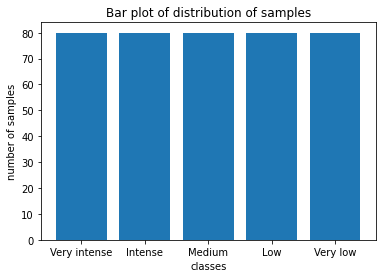

In [8]:
# get a description about dataset
label_set = {
    'Very intense': 4,
    'Intense': 3,
    'Medium': 2,
    'Low': 1,
    'Very low': 0
}

counts =  {}
for label, value in label_set.items():
    counts[label] = len(df[df['Label'] == value])

plt.bar(counts.keys(), counts.values())
plt.ylabel('number of samples')
plt.xlabel('classes')
plt.title('Bar plot of distribution of samples')
plt.show()

In [9]:
# preprocess data
data = df.values[:, :-1]
labels = df.values[:, -1]

# min max scaler
# scale data by multiple values to  (x - max) / (max - min) column wise
scaler = MinMaxScaler()
data = scaler.fit_transform(data)


In [10]:
# reshape data to use in Time series models (RNN neural network)
old_shape = data.shape
# samples, timestamp, feature
data = data.reshape((data.shape[0], data.shape[1], 1))
print('old shape is', old_shape, 'and new shape is ', data.shape)

old shape is (400, 24) and new shape is  (400, 24, 1)


In [11]:
# one hot encoding labels
# this is a travial operation in classification task
# ex : sample with label 2 transform to label 0 0 1 0 0
# labels is 0 1 2 3 4
# so sample with label 2 means that position of 2 set to 1 and others set to 0
labels = to_categorical(labels)

In [12]:
labels[0]

array([0., 0., 0., 0., 1.], dtype=float32)

In [13]:
# split data set to train and test
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

In [14]:
print('number of train samples is ', len(x_train), 'number of test samples is ', len(x_test))

number of train samples is  320 number of test samples is  80


![rnn model](https://www.researchgate.net/publication/329330308/figure/fig1/AS:698826503495682@1543624630550/Basic-recurrent-neural-network-RNN-structure.png)

In [15]:
# define model structure and next training with data.

# create a model instanse
rnn_model = Sequential()
# add RNN layers (24 unit and use 200 neurons in hidden state)
rnn_model.add(SimpleRNN(80, input_shape=data.shape[1:],return_sequences=True))
rnn_model.add(Dropout(.3))
rnn_model.add(SimpleRNN(80))
rnn_model.add(Dropout(.3))
# add a dense layer to improve capability for classification
rnn_model.add(Dense(100))
rnn_model.add(Dropout(.2))
# use LeakyRelu as activation function after dense layer.
rnn_model.add(LeakyReLU(.1))
# use a dense layer with 5 neurons for detecting class fo input data
# we set 5 neurons in this layer because we have 5 class and use sigmoid activation
# because we transform labels to one hot encoded system.
rnn_model.add(Dense(5, activation='sigmoid'))
rnn_model.summary()

#===================================================================

#start training

# compile model structure and set optimizer and loss function to optimize weights
rnn_model.compile(loss=categorical_crossentropy,optimizer=Adam(), metrics= ['accuracy'])
# define network params 
num_epochs = 100 # how long training process does it take?
b_size = 32 # how much samples use in each gradient update

# start training and save accuracy and errors during training to plot curves in future.
history = rnn_model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=b_size,
    validation_data=(x_test, y_test),
    callbacks=[EarlyStopping(patience=5, min_delta=.005)],
    verbose=1
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 24, 80)            6560      
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 80)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 80)                12880     
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               8100      
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100)              

![RNN STRUCTURE](https://www.researchgate.net/publication/329330308/figure/fig1/AS:698826503495682@1543624630550/Basic-recurrent-neural-network-RNN-structure.png)

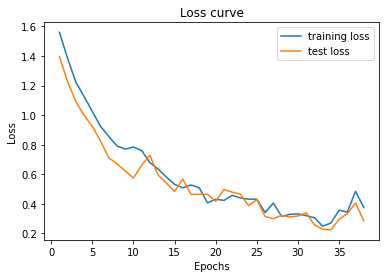

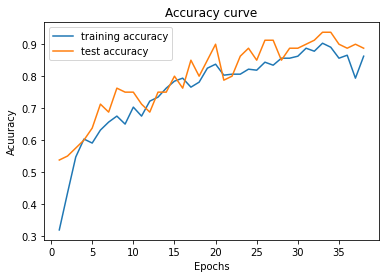

In [16]:
# plot curves of accuracy and loss
trained_epochs = np.arange(1, len(history.history['loss'])+1)

plt.figure(1)
plt.plot(trained_epochs, history.history['loss'], label='training loss')
plt.plot(trained_epochs, history.history['val_loss'], label='test loss')
plt.title('Loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure(2)
plt.plot(trained_epochs, history.history['accuracy'], label='training accuracy')
plt.plot(trained_epochs, history.history['val_accuracy'], label='test accuracy')
plt.title('Accuracy curve')
plt.title('Accuracy curve')
plt.xlabel('Epochs')
plt.ylabel('Acuuracy')
plt.legend()
plt.show()

In [27]:
# get prediction of test data from rnn model and change them to number 0 - 4 instead one hot
y_prediction = np.argmax(rnn_model.predict(x_test), axis=1)
# y_true is true labels of test data that we change them to number 0 - 4
y_true = np.argmax(y_test, axis=1)
# now give y true and prediction result to measure classification metrics.
print(classification_report(y_true, y_prediction, target_names=label_set.keys()))

              precision    recall  f1-score   support

Very intense       0.94      1.00      0.97        16
     Intense       0.94      1.00      0.97        16
      Medium       0.90      0.56      0.69        16
         Low       0.79      0.94      0.86        16
    Very low       0.88      0.94      0.91        16

    accuracy                           0.89        80
   macro avg       0.89      0.89      0.88        80
weighted avg       0.89      0.89      0.88        80



In [28]:
# confusion matrix 
# should be diagonal values greaten than off diagonal values.
# it demonstrates conjestion of class boundry
confusion_matrix(y_true, y_prediction)

array([[16,  0,  0,  0,  0],
       [ 0, 16,  0,  0,  0],
       [ 0,  1,  9,  4,  2],
       [ 0,  0,  1, 15,  0],
       [ 1,  0,  0,  0, 15]])